# Recommendations with IBM

In this notebook, you will be putting your recommendation skills to use on real data from the IBM Watson Studio platform. 


You may either submit your notebook through the workspace here, or you may work from your local machine and submit through the next page.  Either way assure that your code passes the project [RUBRIC](https://review.udacity.com/#!/rubrics/2322/view).  **Please save regularly.**

By following the table of contents, you will build out a number of different methods for making recommendations that can be used for different situations. 


## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
IV. [Content Based Recommendations (EXTRA - NOT REQUIRED)](#Content-Recs)<br>
V. [Matrix Factorization](#Matrix-Fact)<br>
VI. [Extras & Concluding](#conclusions)

At the end of the notebook, you will find directions for how to submit your work.  Let's get started by importing the necessary libraries and reading in the data.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import project_tests as t
import pickle

%matplotlib inline

df = pd.read_csv('data/user-item-interactions.csv')
df_content = pd.read_csv('data/articles_community.csv')
del df['Unnamed: 0']
del df_content['Unnamed: 0']

# Show df to get an idea of the data
df.head()

,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [2]:
# Show df_content to get an idea of the data
df_content.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

Use the dictionary and cells below to provide some insight into the descriptive statistics of the data.

`1.` What is the distribution of how many articles a user interacts with in the dataset?  Provide a visual and descriptive statistics to assist with giving a look at the number of times each user interacts with an article.  

In [3]:
df.head()

,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [4]:
email_counts = df.groupby('email').count().sort_values('title').title

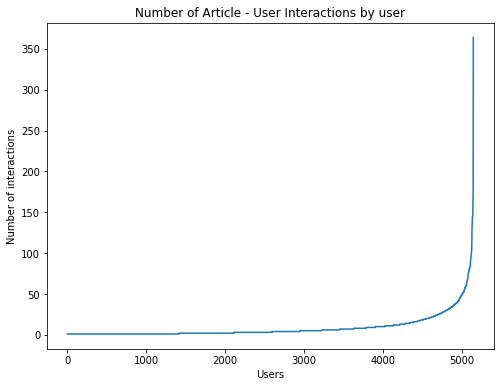

In [5]:
plt.figure(figsize=(8,6))
plt.xlabel('Users')
plt.ylabel('Number of interactions')
plt.title('Number of Article - User Interactions by user')
plt.plot(np.array(email_counts));

In [6]:
# Descriptive statistics of user-article interactions per user.
email_counts.describe()

count    5148.000000
mean        8.930847
std        16.802267
min         1.000000
25%         1.000000
50%         3.000000
75%         9.000000
max       364.000000
Name: title, dtype: float64

In [7]:
df_content.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


In [8]:
# The maximum number of user-article interactions by any 1 user is 364
max_views_by_user = email_counts.max()
max_views_by_user

364

In [9]:
# 50% of individuals interact with 3 number of articles or fewer.
median_val = email_counts.median()
median_val

3.0

`2.` Explore and remove duplicate articles from the **df_content** dataframe.  

In [10]:
# Checking which columns have duplicates

In [11]:
df_content.shape

(1056, 5)

In [12]:
df_content.drop_duplicates('doc_body').shape

(1037, 5)

In [13]:
df_content.drop_duplicates('doc_description').shape

(1023, 5)

In [14]:
df_content.drop_duplicates('doc_full_name').shape

(1051, 5)

In [15]:
df_content.drop_duplicates('article_id').shape

(1051, 5)

In [16]:
# Checking duplicates of doc_description
df_content[df_content.duplicated('doc_description', keep=False) == True].doc_description.unique()

array(['Here’s this week’s news in Data Science and Big Data.',
       'Here’s this week’s news in Data Science and Big Data. ',
       'How to use the Spark machine learning programming model in IBM Analytics for Apache Spark on IBM Bluemix',
       'If you are like most data scientists, you are probably spending a lot of time to cleanse, shape and prepare your data before you can actually start with the more enjoyable part of building and…',
       'Interesting data science links from around the web.', nan,
       'Today’s world of data science leverages data from various sources. Commonly, these sources are Hadoop File System, Enterprise Data Warehouse, Relational Database systems, Enterprise file systems, etc…',
       'Every two weeks, we find the most interesting data science links from around the web and collect them in Data Science Briefings, the DataMiningApps newsletter.',
       'In my last blog “Business differentiation through Machine Learning” I introduced and described t

In [17]:
# Exploring duplicated article ids
df_content[df_content.duplicated('article_id', keep=False) == True].sort_values('article_id')

,doc_body,doc_description,doc_full_name,doc_status,article_id
50,Follow Sign in / Sign up Home About Insight Da...,Community Detection at Scale,Graph-based machine learning,Live,50
365,Follow Sign in / Sign up Home About Insight Da...,During the seven-week Insight Data Engineering...,Graph-based machine learning,Live,50
221,* United States\r\n\r\nIBM® * Site map\r\n\r\n...,When used to make sense of huge amounts of con...,How smart catalogs can turn the big data flood...,Live,221
692,Homepage Follow Sign in / Sign up Homepage * H...,One of the earliest documented catalogs was co...,How smart catalogs can turn the big data flood...,Live,221
232,Homepage Follow Sign in Get started Homepage *...,"If you are like most data scientists, you are ...",Self-service data preparation with IBM Data Re...,Live,232
971,Homepage Follow Sign in Get started * Home\r\n...,"If you are like most data scientists, you are ...",Self-service data preparation with IBM Data Re...,Live,232
399,Homepage Follow Sign in Get started * Home\r\n...,Today’s world of data science leverages data f...,Using Apache Spark as a parallel processing fr...,Live,398
761,Homepage Follow Sign in Get started Homepage *...,Today’s world of data science leverages data f...,Using Apache Spark as a parallel processing fr...,Live,398
578,This video shows you how to construct queries ...,This video shows you how to construct queries ...,Use the Primary Index,Live,577
970,This video shows you how to construct queries ...,This video shows you how to construct queries ...,Use the Primary Index,Live,577


In [18]:
# Removing any rows that have the same article_id - only keeping the first
df_content.drop_duplicates('article_id', inplace=True)

`3.` Use the cells below to find:

**a.** The number of unique articles that have an interaction with a user.  
**b.** The number of unique articles in the dataset (whether they have any interactions or not).<br>
**c.** The number of unique users in the dataset. (excluding null values) <br>
**d.** The number of user-article interactions in the dataset.

In [19]:
# The number of unique articles that have at least one interaction
unique_articles = df.article_id.nunique()
unique_articles

714

In [20]:
# The number of unique articles on the IBM platform
total_articles = df_content.shape[0]  
total_articles

1051

In [21]:
# The number of unique users
email_counts = df.groupby('email').count().sort_values('title').title
unique_users = email_counts.count() 
unique_users

5148

In [22]:
# The number of user-article interactions
user_article_interactions = df.shape[0]
user_article_interactions

45993

`4.` Use the cells below to find the most viewed **article_id**, as well as how often it was viewed.  After talking to the company leaders, the `email_mapper` function was deemed a reasonable way to map users to ids.  There were a small number of null values, and it was found that all of these null values likely belonged to a single user (which is how they are stored using the function below).

In [23]:
# The most viewed article in the dataset as a string with one value following the decimal 
most_viewed_article_id = str(df.article_id.value_counts().index[0])
most_viewed_article_id

'1429.0'

In [24]:
# The most viewed article in the dataset was viewed 937 times
max_views = df[df.article_id == 1429.0].shape[0]
max_views

937

In [25]:
# Mapping user email to user_id column and removing email column

def email_mapper():
    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        email_encoded.append(coded_dict[val])
    return email_encoded

email_encoded = email_mapper()
del df['email']
df['user_id'] = email_encoded

# show header
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


In [26]:
## If you stored all your results in the variable names above, 
## you shouldn't need to change anything in this cell

sol_1_dict = {
    '`50% of individuals have _____ or fewer interactions.`': median_val,
    '`The total number of user-article interactions in the dataset is ______.`': user_article_interactions,
    '`The maximum number of user-article interactions by any 1 user is ______.`': max_views_by_user,
    '`The most viewed article in the dataset was viewed _____ times.`': max_views,
    '`The article_id of the most viewed article is ______.`': most_viewed_article_id,
    '`The number of unique articles that have at least 1 rating ______.`': unique_articles,
    '`The number of unique users in the dataset is ______`': unique_users,
    '`The number of unique articles on the IBM platform`': total_articles
}

# Test your dictionary against the solution
t.sol_1_test(sol_1_dict)

It looks like you have everything right here! Nice job!


### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

Unlike in the earlier lessons, we don't actually have ratings for whether a user liked an article or not.  We only know that a user has interacted with an article.  In these cases, the popularity of an article can really only be based on how often an article was interacted with.

`1.` Fill in the function below to return the **n** top articles ordered with most interactions as the top. Test your function using the tests below.

In [27]:
def get_top_articles(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    
    # Listing article titles by most viewed (highest count per article)
    top_articles = [df[df.article_id == i].title.iloc[0] for i in df.article_id.value_counts().index][0:n]
           
    return top_articles

In [28]:
def get_top_article_ids(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    
    # listing article ids by most viewed
    top_articles = [i for i in df.article_id.value_counts().index][0:n]
    
    # coverting list elements to string format
    top_articles = [str(top_articles[i]) for i in range(n)]
 
    return top_articles

In [29]:
# Test your function by returning the top 5, 10, and 20 articles
top_5 = get_top_articles(5)
top_10 = get_top_articles(10)
top_20 = get_top_articles(20)

# Test each of your three lists from above
t.sol_2_test(get_top_articles)

Your top_5 looks like the solution list! Nice job.
Your top_10 looks like the solution list! Nice job.
Your top_20 looks like the solution list! Nice job.


### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>


`1.` Use the function below to reformat the **df** dataframe to be shaped with users as the rows and articles as the columns.  

* Each **user** should only appear in each **row** once.


* Each **article** should only show up in one **column**.  


* **If a user has interacted with an article, then place a 1 where the user-row meets for that article-column**.  It does not matter how many times a user has interacted with the article, all entries where a user has interacted with an article should be a 1.  


* **If a user has not interacted with an item, then place a zero where the user-row meets for that article-column**. 

Use the tests to make sure the basic structure of your matrix matches what is expected by the solution.

In [30]:
# create the user-article matrix with 1's and 0's

def create_user_item_matrix(df):
    '''
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
    user_item - user item matrix 
    
    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
    an article and a 0 otherwise
    '''
    
    # multiply by 1 to convert True to 1s
    user_item = (df.groupby(['user_id', 'article_id'])['title'].any().unstack().fillna(value=0)*1).astype(int)
        
    return user_item

user_item = create_user_item_matrix(df)

In [31]:
create_user_item_matrix(df).head()

article_id,0.0,2.0,4.0,8.0,9.0,12.0,14.0,15.0,16.0,18.0,...,1434.0,1435.0,1436.0,1437.0,1439.0,1440.0,1441.0,1442.0,1443.0,1444.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [32]:
## Tests: You should just need to run this cell.  Don't change the code.
assert user_item.shape[0] == 5149, "Oops!  The number of users in the user-article matrix doesn't look right."
assert user_item.shape[1] == 714, "Oops!  The number of articles in the user-article matrix doesn't look right."
assert user_item.sum(axis=1)[1] == 36, "Oops!  The number of articles seen by user 1 doesn't look right."
print("You have passed our quick tests!  Please proceed!")

You have passed our quick tests!  Please proceed!


`2.` Complete the function below which should take a user_id and provide an ordered list of the most similar users to that user (from most similar to least similar).  The returned result should not contain the provided user_id, as we know that each user is similar to him/herself. Because the results for each user here are binary, it (perhaps) makes sense to compute similarity as the dot product of two users. 

Use the tests to test your function.

In [33]:
def find_similar_users(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered
    
    '''
   
    # open dot_prod_users pickle if it exists
    try:
        with open("user_pickle", 'rb') as f:
            dot_prod_users = pickle.load(f)
    
    # otherwise calculate dot_prod_users from user_item and save as pickle
    except:
        user_item_np = np.array(user_item)
        dot_prod_users = user_item_np.dot(np.transpose(user_item_np))
        with open("user_pickle", "wb") as f:
            pickle.dump(dot_prod_users, f)
    
   
    assert user_id >=1, "user_id must be >= 1"
    
    # get sorted index positions, flip to sort from highest to lowest
    # subtracting 1 to convert used_id to index and adding 1 to convert back to user_id
    most_similar_users = np.flip(np.argsort(dot_prod_users[user_id-1]) +1, axis=0)  
    
    # find user's own index position 
    delete_self_index = np.where(most_similar_users==user_id)
    
    # remove the user's own id
    most_similar_users = np.delete(most_similar_users, delete_self_index)
      
    return most_similar_users

In [34]:
# Do a spot check of your function
print("The 10 most similar users to user 1 are: {}".format(find_similar_users(1)[:10]))
print("The 5 most similar users to user 3933 are: {}".format(find_similar_users(3933)[:5]))
print("The 3 most similar users to user 46 are: {}".format(find_similar_users(46)[:3]))

The 10 most similar users to user 1 are: [3933   23 3782  203 4459  131 3870   46 4201 5041]
The 5 most similar users to user 3933 are: [   1   23 3782 4459  203]
The 3 most similar users to user 46 are: [4201   23 3782]


`3.` Now that you have a function that provides the most similar users to each user, you will want to use these users to find articles you can recommend.  Complete the functions below to return the articles you would recommend to each user. 

In [35]:
def get_article_names(article_ids, df=df):
    '''
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column)
    '''
    article_names = df[df.article_id.isin(article_ids)].title.unique()
    
    return article_names 

In [36]:
article_ids = [1430, 1314, 1429]
get_article_names(article_ids)

array([ 'using pixiedust for fast, flexible, and easier data analysis and experimentation',
       'healthcare python streaming application demo',
       'use deep learning for image classification'], dtype=object)

In [37]:
def get_user_articles(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the doc_full_name column in df_content)
    
    Description:
    Provides a list of the article_ids and article titles that have been seen by a user
    '''
    
    # get article ids viewed by user and covert to numpy array of integers, then to list
    try:
        article_ids = list(np.array([user_item.columns[i] for i in np.where(user_item.loc[user_id] > 0)]).astype(int)[0])
    except:
        return [], []
        
    # get list of article names from article ids
    article_names = df[df.article_id.isin(article_ids)].drop_duplicates('title').title
    
    # convert article_ids into list of strings     
    article_ids = [str(i) + ".0" for i in article_ids]
    
    return article_ids, article_names  

In [38]:
def user_user_recs(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    Users who are the same closeness are chosen arbitrarily as the 'next' user
    
    For the user where the number of recommended articles starts below m 
    and ends exceeding m, the last items are chosen arbitrarily
    
    '''
    recs = []
    
    for i in find_similar_users(user_id):
        
        # if recs is empty, add article ids to recs that have not been seen by user_id  
        if len(recs) <= 0:
            suggest_articles = np.setdiff1d(get_user_articles(i)[0] , get_user_articles(user_id)[0])
        # add article ids to recs that are not already in recs
        else:
            suggest_articles = np.setdiff1d(get_user_articles(i)[0] , recs)
        recs.extend(suggest_articles)
        
        if len(recs) >= m:
            break
    
    # only return top m recommendations 
    if len(recs) >= m:
        recs = recs[:m]
    
    return recs

In [39]:
# Check Results
get_article_names(user_user_recs(1, 10)) # Return 10 recommendations for user 1

array(['analyze energy consumption in buildings',
       'analyze accident reports on amazon emr spark',
       '520    using notebooks with pixiedust for fast, flexi...\nName: title, dtype: object',
       '1448    i ranked every intro to data science course on...\nName: title, dtype: object',
       'data tidying in data science experience',
       'airbnb data for analytics: vancouver listings',
       'recommender systems: approaches & algorithms',
       'airbnb data for analytics: mallorca reviews',
       'analyze facebook data using ibm watson and watson studio',
       'a tensorflow regression model to predict house values'], dtype=object)

In [40]:
# Test your functions here - No need to change this code - just run this cell
assert set(get_article_names(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_article_names(['1320.0', '232.0', '844.0'])) == set(['housing (2015): united states demographic measures','self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_user_articles(20)[0]) == set(['1320.0', '232.0', '844.0'])
assert set(get_user_articles(20)[1]) == set(['housing (2015): united states demographic measures', 'self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook'])
assert set(get_user_articles(2)[0]) == set(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])
assert set(get_user_articles(2)[1]) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis'])
print("If this is all you see, you passed all of our tests!  Nice job!")

If this is all you see, you passed all of our tests!  Nice job!


`4.` Now we are going to improve the consistency of the **user_user_recs** function from above.  

* Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - choose the users that have the most total article interactions before choosing those with fewer article interactions.


* Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, choose articles with the articles with the most total interactions before choosing those with fewer total interactions. This ranking should be  what would be obtained from the **top_articles** function you wrote earlier.

In [41]:
def get_top_sorted_users(user_id, df=df, user_item=user_item):
    '''
    INPUT:
    user_id - (int)
    df - (pandas dataframe) df as defined at the top of the notebook 
    user_item - (pandas dataframe) matrix of users by articles: 
            1's when a user has interacted with an article, 0 otherwise
    
            
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - the number of articles viewed by the user - if a u
                    
    Other Details - sort the neighbors_df by the similarity and then by number of interactions where 
                    highest of each is higher in the dataframe
     
    '''
    # get list of similar users to user_id    
    similar_users = find_similar_users(user_id)
    
    # load dot product matrix of user_item, calculate if not available 
    try:
        with open("user_pickle", 'rb') as f:
            dot_prod_users = pickle.load(f)
    except:
        user_item_np = np.array(user_item.fillna(value=0))
        dot_prod_users = user_item_np.dot(np.transpose(user_item_np))
    
    # get similarity (as defined by dot product) for each similar user to user_id
    similarity_list = [dot_prod_users[user_id -1][i-1] for i in similar_users]
    
    # get article popularity (as defined by total number of user interactions)
    num_interactions = user_item.sum(axis=1)
    
    # create datafrane of neighbour_id vs interations
    neighbor_list_df = pd.DataFrame({"neighbor_id": num_interactions.index, 'num_interactions': num_interactions.values})
    
    # create dataframe of neighbour id vs similarity 
    similarities_df =pd.DataFrame({"neighbor_id": similar_users, "similarity": similarity_list})

    # merge previous two dataframes by neighbour id and sort by similarity and user article interactions
    neighbors_df = pd.merge(similarities_df, neighbor_list_df, on=['neighbor_id']).sort_values(
                            ['similarity', 'num_interactions', 'neighbor_id'], ascending=False)
    
    return neighbors_df

In [42]:
get_top_sorted_users(5).head()

,neighbor_id,similarity,num_interactions
0,3782,3,135
8,23,3,135
5,49,3,101
10,3697,3,100
13,4459,3,96


In [43]:
get_top_articles(10)

['use deep learning for image classification',
 'insights from new york car accident reports',
 'visualize car data with brunel',
 'use xgboost, scikit-learn & ibm watson machine learning apis',
 'predicting churn with the spss random tree algorithm',
 'healthcare python streaming application demo',
 'finding optimal locations of new store using decision optimization',
 'apache spark lab, part 1: basic concepts',
 'analyze energy consumption in buildings',
 'gosales transactions for logistic regression model']

In [44]:
def user_user_recs_part2(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    * Choose the users that have the most total article interactions 
    before choosing those with fewer article interactions.

    * Choose articles with the articles with the most total interactions 
    before choosing those with fewer total interactions. 
   
    '''
    
    # get list of similar users sorted
    similar_users = get_top_sorted_users(user_id).neighbor_id.values
        
    rec_names = []
    
    for i in similar_users:
        
        # if recs is empty, add article ids to recs that have not been seen by user_id  
        if len(rec_names) == 0:
            rec_names.extend(get_top_articles(m-len(rec_names), df=df[df.user_id == i]))
        
        # add article ids to recs that are not already in recs
        else:
            rec_names.extend(np.setdiff1d(get_top_articles(m-len(rec_names), df=df[df.user_id == i]), rec_names))
                        
        if len(rec_names) >= m:
            break
    
    # get recs from rec_names
    recs = [df[df.title == i].article_id.values[0] for i in rec_names]
    
    return recs, rec_names

In [45]:
# Quick spot check - don't change this code - just use it to test your functions
rec_ids, rec_names = user_user_recs_part2(20, 10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

The top 10 recommendations for user 20 are the following article ids:
[609.0, 1162.0, 1368.0, 880.0, 415.0, 876.0, 967.0, 1172.0, 221.0, 813.0]

The top 10 recommendations for user 20 are the following article names:
['simple linear regression? do it the bayesian way', 'analyze energy consumption in buildings', 'putting a human face on machine learning', 'probabilistic graphical models tutorial\u200a—\u200apart 1 – stats and bots', 'using machine learning to predict value of homes on airbnb', 'statistical bias types explained', 'ml algorithm != learning machine', 'apache spark lab, part 3: machine learning', 'how smart catalogs can turn the big data flood into an ocean of opportunity', 'generative adversarial networks (gans)']


In [46]:
get_top_sorted_users(1).iloc[0].neighbor_id

3933

In [47]:
get_top_sorted_users(131).iloc[10].neighbor_id

242

`5.` Use your functions from above to correctly fill in the solutions to the dictionary below.  Then test your dictionary against the solution.  Provide the code you need to answer each following the comments below.

In [48]:
### Tests with a dictionary of results

user1_most_sim = get_top_sorted_users(1).iloc[0].neighbor_id # Find the user that is most similar to user 1 
user131_10th_sim = get_top_sorted_users(131).iloc[10].neighbor_id # Find the 10th most similar user to user 131

In [49]:
## Dictionary Test Here
sol_5_dict = {
    'The user that is most similar to user 1.': user1_most_sim, 
    'The user that is the 10th most similar to user 131': user131_10th_sim,
}

t.sol_5_test(sol_5_dict)

This all looks good!  Nice job!


`6.` If we were given a new user, which of the above functions would you be able to use to make recommendations?  Explain.  Can you think of a better way we might make recommendations?  Use the cell below to explain a better method for new users.

I would use the get_top_articles function alone and just recommend the top articles that have been most interacted with by the current user base.

`7.` Using your existing functions, provide the top 10 recommended articles you would provide for the a new user below.  You can test your function against our thoughts to make sure we are all on the same page with how we might make a recommendation.

In [50]:
new_user = '0.0'

# What would your recommendations be for this new user '0.0'?  As a new user, they have no observed articles.
# Provide a list of the top 10 article ids you would give to 
new_user_recs =  get_top_article_ids(10)
new_user_recs

['1429.0',
 '1330.0',
 '1431.0',
 '1427.0',
 '1364.0',
 '1314.0',
 '1293.0',
 '1170.0',
 '1162.0',
 '1304.0']

In [51]:
assert set(new_user_recs) == set(['1314.0','1429.0','1293.0','1427.0','1162.0','1364.0','1304.0','1170.0','1431.0','1330.0']), "Oops!  It makes sense that in this case we would want to recommend the most popular articles, because we don't know anything about these users."

print("That's right!  Nice job!")

That's right!  Nice job!


### <a class="anchor" id="Matrix-Fact">Part V: Matrix Factorization</a>

In this part of the notebook, you will use matrix factorization to make article recommendations to the users on the IBM Watson Studio platform.

`1.` You should have already created a **user_item** matrix above in **question 1** of **Part III** above.  This first question here will just require that you run the cells to get things set up for the rest of **Part V** of the notebook. 

In [55]:
# Load the matrix here
user_item_matrix = pd.read_pickle('user_item_matrix.p')

In [56]:
# quick look at the matrix
user_item_matrix.head()

article_id,0.0,100.0,1000.0,1004.0,1006.0,1008.0,101.0,1014.0,1015.0,1016.0,...,977.0,98.0,981.0,984.0,985.0,986.0,990.0,993.0,996.0,997.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


`2.` In this situation, you can use Singular Value Decomposition from [numpy](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.linalg.svd.html) on the user-item matrix.  Use the cell to perform SVD, and explain why this is different than in the lesson.

In [57]:
# Perform SVD on the User-Item Matrix Here
u, s, vt = np.linalg.svd(user_item_matrix)

In [58]:
u.shape, s.shape, vt.shape

((5149, 5149), (714,), (714, 714))

SVD can only be performed on a matrix that is not sparse. In the case of ratings, a value of NaN indicates that the user has not yet rated the movie. It does not suggest that the movie should necessarily have a rating of zero, rather that the rating is unknown. Conversely, in this case, the article "rating" is measured using popularity (as measured by the number of times an article is accessed) as a proxy for rating. Therefore a value of zero for a particular user is directly refletive of the "rating" that we are assigning to the article. Hence even though the user_item matrix is largely filled with zeros, these represent actual values measured and therefore the matrix is not necessarily sparse and we are able to perform SVD on it.   

`3.` Now for the tricky part, how do we choose the number of latent features to use?  Running the below cell, you can see that as the number of latent features increases, we obtain a lower error rate on making predictions for the 1 and 0 values in the user-item matrix.  Run the cell below to get an idea of how the accuracy improves as we increase the number of latent features.

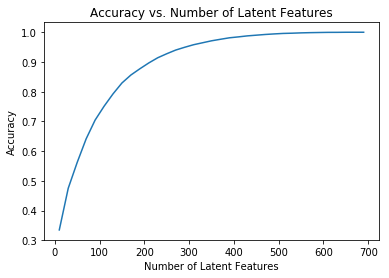

In [59]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_matrix, user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0])
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

`4.` From the above, we can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of if we are able to make good recommendations.  Instead, we might split our dataset into a training and test set of data, as shown in the cell below.  

Use the code from question 3 to understand the impact on accuracy of the training and test sets of data with different numbers of latent features. Using the split below: 

* How many users can we make predictions for in the test set?  
* How many users are we not able to make predictions for because of the cold start problem?
* How many articles can we make predictions for in the test set?  
* How many articles are we not able to make predictions for because of the cold start problem?

In [60]:
df_train = df.head(40000)
df_test = df.tail(5993)

def create_test_and_train_user_item(df_train, df_test):
    '''
    INPUT:
    df_train - training dataframe
    df_test - test dataframe
    
    OUTPUT:
    user_item_train - a user-item matrix of the training dataframe 
                      (unique users for each row and unique articles for each column)
    user_item_test - a user-item matrix of the testing dataframe 
                    (unique users for each row and unique articles for each column)
    test_idx - all of the test user ids
    test_arts - all of the test article ids
    
    '''
    
    user_item_train = create_user_item_matrix(df_train)
    user_item_test = create_user_item_matrix(df_test)
    
    test_idx = list(user_item_test.index)
    test_arts = list(user_item_test.columns)
    
    return user_item_train, user_item_test, test_idx, test_arts

user_item_train, user_item_test, test_idx, test_arts = create_test_and_train_user_item(df_train, df_test)

In [61]:
# shapes of training and testing matrices 
user_item_train.shape, user_item_test.shape

((4487, 714), (682, 574))

In [62]:
# How many users can we make predictions for in the test set?
np.intersect1d(user_item_test.index, user_item_train.index).shape[0]

20

In [63]:
# How many users in the test set are we not able to make predictions for because of the cold start problem?
user_item_test.shape[0] - np.intersect1d(user_item_test.index, user_item_train.index).shape[0]

662

In [64]:
# How many articles can we make predictions for in the test set?
np.intersect1d(user_item_test.columns, user_item_train.columns).shape[0]

574

In [65]:
# How many articles in the test set are we not able to make predictions for because of the cold start problem?
user_item_test.shape[1] - np.intersect1d(user_item_test.columns, user_item_train.columns).shape[0]

0

In [66]:
# Replace the values in the dictionary below
a = 662
b = 574
c = 20 
d = 0 

sol_4_dict = {
    'How many users can we make predictions for in the test set?': c,
    'How many users in the test set are we not able to make predictions for because of the cold start problem?': a, 
    'How many articles can we make predictions for in the test set?': b,
    'How many articles in the test set are we not able to make predictions for because of the cold start problem?': d
}

#t.sol_4_test(sol_4_dict)
# seems to be an error in project_test.py file that checks this

`5.` Now use the **user_item_train** dataset from above to find U, S, and V transpose using SVD. Then find the subset of rows in the **user_item_test** dataset that you can predict using this matrix decomposition with different numbers of latent features to see how many features makes sense to keep based on the accuracy on the test data. This will require combining what was done in questions `2` - `4`.

Use the cells below to explore how well SVD works towards making predictions for recommendations on the test data.  

In [67]:
# fit SVD on the user_item_train matrix
u_train, s_train, vt_train = np.linalg.svd(user_item_train) 

In [68]:
def intersect_finder(train_data, test_data):
    '''
    Returns lists of column and row indice by name as well as integer-location that are common to both train and test data. 
        
    INPUT:
    training_data - training dataframe
    test_data - test dataframe
    
    OUTPUT:
    column_intersect - column names common to train_data and test_data
    row_intersect - row names common to train_data and test_data
    column_indices - integer-location of column_intersect     
    row_indices - integer-location of row_intersect 
    
    '''
       
    column_intersect = np.intersect1d(user_item_test.columns, user_item_train.columns)
    row_intersect = np.intersect1d(user_item_test.index, user_item_train.index)
    column_indices = [user_item_train.columns.get_loc(c) for c in column_intersect]
    row_indices = [user_item_train.index.get_loc(c) for c in row_intersect]
        
    return column_intersect, row_intersect, column_indices, row_indices    

In [69]:
column_intersect, row_intersect, column_indices, row_indices = intersect_finder(user_item_train, user_item_test)

In [70]:
# df dataframe containing only data where test and training datasets intersect
df_test = df[df.article_id.isin(column_intersect)][df.user_id.isin(row_intersect)]

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


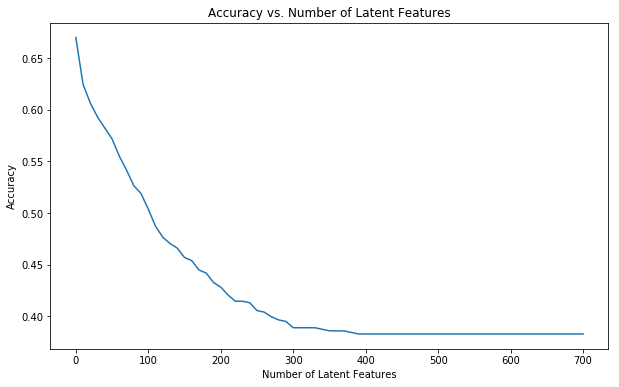

In [71]:
# graphing latent feautres up to 700

num_latent_feats = np.arange(0,700+10, 10)
sum_errs = []

for k in num_latent_feats:
    
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s_train[:k]), u_train[:, :k], vt_train[:k, :]
    
    # estimate taking dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # calculate difference between test and prediction for only user_ids and articles common to both train and test data.
    diffs = np.subtract(user_item_test[column_intersect].loc[row_intersect], 
                        user_item_est[row_indices][:, column_indices])
        
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)

plt.figure(figsize=(10,6))
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df_test.shape[0])
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

In [72]:
# Calculating results

min_error = min(sum_errs)
max_acc = round((1 - np.array(min(sum_errs))/df_test.shape[0]) * 100, 2)
opt_lat = sum_errs.index(min(sum_errs))*20 + 1
no_change = sum_errs.index(sum_errs[-1])*10 + 1
acc_no_change = round(((1 - np.array(sum_errs[-1])/df_test.shape[0]) * 100), 2)

print("Minimum error: {}".format(min(sum_errs)))
print("Maximum accuracy: {}%".format(max_acc))
print("Optimal latent features: {}".format(opt_lat))
print("Number latent features after which no further accuracy change: {}".format(no_change))
print("Accuracy with 391 latent features: {}%".format(acc_no_change))
print("Model accuracy difference between max and no further change: {}%".format(round((acc_no_change - max_acc),2 )))

Minimum error: 218.0
Maximum accuracy: 67.02%
Optimal latent features: 1
Number latent features after which no further accuracy change: 391
Accuracy with 391 latent features: 38.28%
Model accuracy difference between max and no further change: -28.74%


`6.` Use the cell below to comment on the results you found in the previous question. Given the circumstances of your results, discuss what you might do to determine if the recommendations you make with any of the above recommendation systems are an improvement to how users currently find articles? 

When computing the accuracy using test data instead of the full dataset, we see that there is a fall in accuracy the more latent features are added. The optimal number of latent features is only 1 with an accuracy of 67.02%. 

Using only one latent features is essentially equivalent to recommending each user the most popular articles. As more latent features are added accuracy falls and eventually levels out with 38.28% accuracy with 391+ latent features. This is a drop in accuracy of 28.74% and is due to overfitting of the data.

To determine whether these recommendation systems are an improvement over the user's current way of finding articles we would need to set up an A/B test to compare the new systems vs current method. 

The null hypothesis in this case would be that there is no difference between which articles are viewed by a new user using the new recommendation system vs the articles viewed by a new user using the current method of finding articles.

<a id='conclusions'></a>
### Extras
Using your workbook, you could now save your recommendations for each user, develop a class to make new predictions and update your results, and make a flask app to deploy your results.  These tasks are beyond what is required for this project.  However, from what you learned in the lessons, you certainly capable of taking these tasks on to improve upon your work here!


## Conclusion

> Congratulations!  You have reached the end of the Recommendations with IBM project! 


## Directions to Submit

> Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).

> Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.

> Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations! 

In [73]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Recommendations_with_IBM.ipynb'])

0